In [1]:
import matplotlib.pyplot as plt
img_path = '../resources/sand_480270.jpg'

In [2]:
from resize_package import generate_horizontal_filter, generate_vertical_filter

In [3]:
# Load in image
import numpy as np
from PIL import Image

def decompose_image(file_path):
    # Open the image file
    img = Image.open(file_path)
    
    # Convert the image to a NumPy array
    img_array = np.array(img)
    
    # Check if the image is RGB
    if len(img_array.shape) != 3 or img_array.shape[2] != 3:
        raise ValueError("The image must be in RGB format")
    
    # Decompose into R, G, B channels
    r_channel = img_array[:, :, 0]
    g_channel = img_array[:, :, 1]
    b_channel = img_array[:, :, 2]
    
    
    return r_channel, g_channel, b_channel

src_h, src_w = 270, 480
print(src_h,src_w)
dst_h, dst_w = 135,240 

270 480


In [4]:
def build_horizontal_matrix():
    h_pos, h_coeffs = generate_horizontal_filter(src_w, dst_w)
    # Create sparse matrix for horizontal scaling
    H = np.zeros((src_w, dst_w))
    filter_size = 4
    print(H.shape)
    # Fill in the matrix based on filter positions and coefficients
    for x in range(dst_w):
        src_pos = h_pos[x]
        for z in range(filter_size):  # Using filter size of 4
            if src_pos + z < src_w:
                H[src_pos + z, x] = h_coeffs[x * filter_size + z]# Normalize by FILTER_BITS 
    return H

In [5]:
def build_vertical_matrix():
    print(src_h, dst_h)
    v_pos, v_coeffs = generate_vertical_filter(src_h, dst_h)
    # Create sparse matrix for vertical scaling
    V = np.zeros((dst_h, src_h))
    filter_size = 4
    # Fill in the matrix based on filter positions and coefficients
    for y in range(dst_h):
        src_pos = v_pos[y]
        for z in range(filter_size):
            if src_pos + z < src_h:
                V[y, src_pos + z] = v_coeffs[y * filter_size + z]  # Normalize by FILTER_BITS
    return V

(480, 240)
270 135


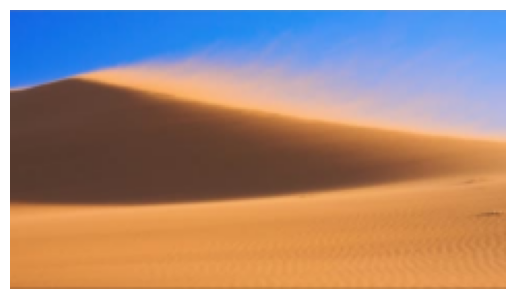

In [7]:
W = build_horizontal_matrix()
H = build_vertical_matrix()
r, g, b = decompose_image(img_path)
r = np.array(r)
r_resize = H @ r @ W
g = np.array(g)
g_resize = H @ g @ W
b = np.array(b)
b_resize = H @ b @ W
# Combine channels back into RGB image
resized_img = np.dstack((r_resize, g_resize, b_resize))/ (1<<22)
resized_img = np.clip(resized_img, 0, 255).astype(np.uint8)
# Set figure size to match image dimensions
plt.imshow(resized_img)
plt.axis('off')
plt.show()


(480, 240)
270 135


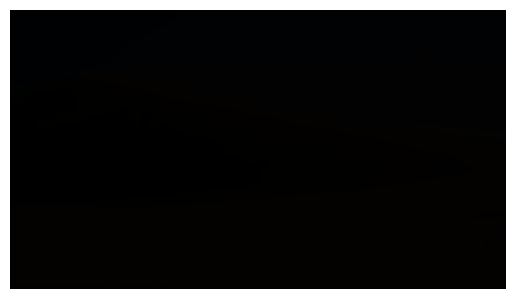

In [8]:
W = build_horizontal_matrix()
H = build_vertical_matrix()
r, g, b = decompose_image(img_path)
r = np.array(r)
r_resize = H @ r @ W
g = np.array(g)
g_resize = H @ g @ W
b = np.array(b)
b_resize = H @ b @ W
# Combine channels back into RGB image
resized_img = np.dstack((r_resize, g_resize, b_resize))/ (1<<28)
resized_img = np.clip(resized_img, 0, 255).astype(np.uint8)
# Set figure size to match image dimensions
plt.imshow(resized_img)
plt.axis('off')
plt.show()


### H @ R @ W where H and W can be precompute
### H size : (dst_h, src_h)
### W size : (src_w, dst_w)  
### Prove: (aH)@r@(Wb) =a@r_resize@b

In [9]:
def multiply(A, B, modulus):
    """
    Perform modular matrix multiplication A @ B % modulus without intermediate overflow.
    Args:
        A (np.ndarray): Left matrix.
        B (np.ndarray): Right matrix.
        modulus (int): The modulus to apply.
    Returns:
        np.ndarray: Result of (A @ B) % modulus.
    """
    # Ensure matrices have compatible shapes
    assert A.shape[1] == B.shape[0], "Matrix dimensions do not match for multiplication."

    # Initialize the result matrix
    result = np.zeros((A.shape[0], B.shape[1]), dtype=np.uint64)

    # Perform element-wise modular multiplication and summation
    for i in range(A.shape[0]):  # Rows of A
        for j in range(B.shape[1]):  # Columns of B
            # Compute each element of the result matrix
            for k in range(A.shape[1]):
                intermediate_product = int(A[i, k]) * int(B[k, j]) % modulus
                result[i,j]  = (result[i,j] + intermediate_product) % modulus
            # result[i, j] = sum((A[i, k] * B[k, j]) % modulus for k in range(A.shape[1])) % modulus

    return result


In [63]:
# Public Setup for Freivald's mod 2^64 (not realy secure)
# for python, it's not safe to use 2**64 due to the overflow problem.
goldilocks_prime = 2**63 - 2**32 + 1
freivalds_randomness_left = np.random.randint(0, goldilocks_prime - 1, size=135, dtype=np.uint64).reshape(1,-1)
freivalds_randomness_right = np.random.randint(0, goldilocks_prime - 1, size=240, dtype=np.uint64).reshape(-1,1)
rLeftTB = multiply(freivalds_randomness_left, H, goldilocks_prime ) 
rRightTB = multiply(W , freivalds_randomness_right, goldilocks_prime )
r_resize_2 = multiply(multiply(H,r, goldilocks_prime) , W,goldilocks_prime)

# # Verify
# assert(((rLeftTB @ r) @ rRightTB) == (freivalds_randomness_left @ r_blurred) @ freivalds_randomness_right)
print(multiply(multiply(rLeftTB,r, goldilocks_prime) , rRightTB, goldilocks_prime))
print(multiply(multiply(freivalds_randomness_left, r_resize_2, goldilocks_prime) , freivalds_randomness_right,goldilocks_prime))

[[6224794376291997594]]
[[6224794376291997594]]


In [10]:
# Save r matrix
with open('../resources/r_matrix.txt', 'w') as f:
    for row in r:
        # Convert row to strings and join with spaces
        line = ' '.join(map(str, row))
        f.write(line + '\n')

# Save r_resize_2 matrix 
with open('../resources/r_resize_matrix.txt', 'w') as f:
    r_tmp = r_resize / (1<<28)
    r_tmp = r_tmp.astype(np.int64)
    for row in r_tmp:
        # Convert row to strings and join with spaces
        line = ' '.join(map(str, row))
        f.write(line + '\n')


H matrix ((135, 270)):
Non-zero elements: 539
Total elements: 36450
Sparsity: 98.52%

W matrix ((480, 240)):
Non-zero elements: 240
Total elements: 115200
Sparsity: 99.79%


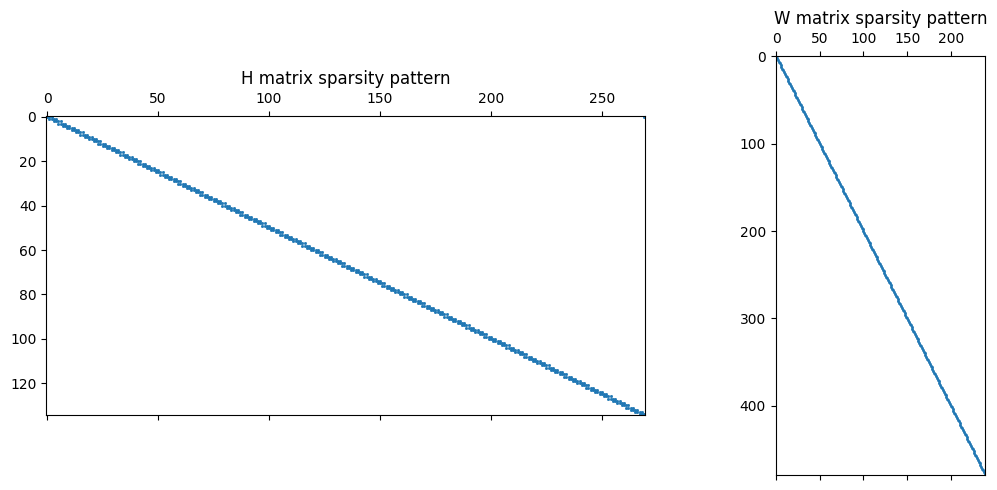

In [27]:
# Analyze sparsity of H and W matrices
h_nonzero = np.count_nonzero(H)
h_total = H.size
h_sparsity = 1 - (h_nonzero / h_total)

w_nonzero = np.count_nonzero(W) 
w_total = W.size
w_sparsity = 1 - (w_nonzero / w_total)

print(f"H matrix ({H.shape}):")
print(f"Non-zero elements: {h_nonzero}")
print(f"Total elements: {h_total}")
print(f"Sparsity: {h_sparsity:.2%}")
print()

print(f"W matrix ({W.shape}):")
print(f"Non-zero elements: {w_nonzero}")
print(f"Total elements: {w_total}") 
print(f"Sparsity: {w_sparsity:.2%}")

# Visualize the sparsity patterns
plt.figure(figsize=(12,5))

plt.subplot(121)
plt.spy(H, markersize=1)
plt.title("H matrix sparsity pattern")

plt.subplot(122)
plt.spy(W, markersize=1)
plt.title("W matrix sparsity pattern")

plt.tight_layout()
plt.show()


In [ ]:
# todo, write in succinct:
# todo, (1<<28)